In [1]:
from cmsisdsp import arm_float_to_q31, arm_cos_f32, arm_mult_q31, arm_rfft_q31, arm_cmplx_mag_q31, arm_rfft_instance_q31, arm_rfft_init_q31
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

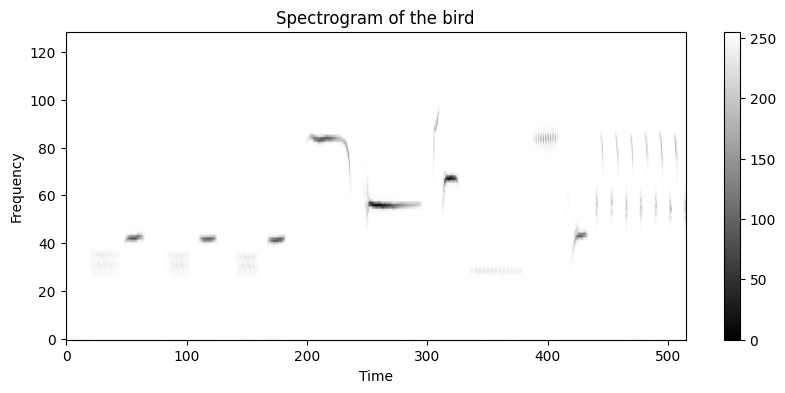

In [2]:
audio_sample_rate, audio_samples = wavfile.read(f'dataset/wavfiles/18387-0.wav')

PI = 3.141592653589793

# Putting this all together
window_size = 256
step_size = 128

# Convert the audio to q31
audio_samples_q31 = arm_float_to_q31(audio_samples)

# Calculate the number of windows
number_of_windows = int((len(audio_samples) - window_size) / step_size) + 1

# Calculate the FFT Output size
fft_size = int(window_size // 2 + 1)

# Create an empty array to hold the Spectrogram
spectrogram_q31 = np.empty((number_of_windows, fft_size))

start_index = 0


# ! CREATE HANNING WINDOW
hanning_window_f32 = np.zeros(window_size)

for i in range(window_size):
	hanning_window_f32[i] = 0.5 * (1 - arm_cos_f32(2 * PI * i / window_size ))

hanning_window_q31 = arm_float_to_q31(hanning_window_f32)

# ! Initialize the FFT instance
rfft_instance_q31 = arm_rfft_instance_q31()
status = arm_rfft_init_q31(rfft_instance_q31, window_size, 0, 1)


# Apply hanning window and apply fft
for index in range(number_of_windows):
	# Take the window from the waveform.
	audio_window_q31 = audio_samples_q31[start_index:start_index + window_size]

	# Apply the Hanning Window.
	processed_audio_q31 = arm_mult_q31(audio_window_q31, hanning_window_q31)

	# Calculate the FFT
	rfft_q31 = arm_rfft_q31(rfft_instance_q31, processed_audio_q31)

	# Take the absolute value of the FFT and add to the Spectrogram.
	rfft_mag_q31 = arm_cmplx_mag_q31(rfft_q31)[:fft_size]

	spectrogram_q31[index] = rfft_mag_q31

	# Increase the start index of the window by the overlap amount.
	start_index += step_size


#print(spectrogram_q31[10])
# print(spectrogram_q31.shape)

#plt.imshow(spectrogram_q31)
# plot the spectrogram
plt.figure(figsize=(10, 4))

def scale_minmax(X, min=0.0, max=1.0):
	X_std = (X - X.min()) / (X.max() - X.min())
	X_scaled = X_std * (max - min) + min
	return X_scaled

plt.imshow(255 - scale_minmax(spectrogram_q31.T, 0, 255), aspect='auto', origin='lower', cmap="gray",)
plt.title('Spectrogram of the bird')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()